# Set up paths

In [1]:
# Specify the lib path
lib_path<-paste(getwd(),'/hana_reanalysis_lib_r42',sep='')
print(lib_path)

# Set the path
.libPaths(lib_path)
.libPaths()

#Set the vis device
setHook(packageEvent("grDevices", "onLoad"),
function(...) grDevices::X11.options(type='cairo'))
options(device='x11')

[1] "/v-data2/matt_davenport/HaNa_RE/HaNa_Reanalysis/hana_reanalysis_lib_r42"


[1] "/v-data2/matt_davenport/HaNa_RE/HaNa_Reanalysis/hana_reanalysis_lib_r42"
[2] "/home/mdavenport/bin/R4.2.1/R-4.2.1/library"

# 7 - PCA and boostrapped heirarchies (cut analyses)

## first make a node and gender sepparated list

In [2]:
gen_list <- readRDS('gen_list.rds')

In [3]:
pca_list<-list()
pca_list$m_an <- gen_list$m_an
pca_list$f_an <- gen_list$f_an
pca_list$m_dn <- gen_list$m_dn
pca_list$f_dn <- gen_list$f_dn
pca_list$m_str <- gen_list$m_str
pca_list$f_str <- gen_list$f_str
pca_list$m_la <- gen_list$m_la
pca_list$f_la <- gen_list$f_la



pca_list$all_an  <- rbind(pca_list$m_an, pca_list$f_an)
pca_list$all_dn  <- rbind(pca_list$m_dn, pca_list$f_dn)
pca_list$all_str <- rbind(pca_list$m_str, pca_list$f_str)
pca_list$all_la  <- rbind(pca_list$m_la, pca_list$f_la)

head(pca_list$m_an)
head(pca_list$all_an)

,sample_id,animal,sex,dose,pallia,region,song_capable,node,song_system,gene_id,fpkm
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,me_lman_1,g,m,e,nido,lman,y,an,y,A1CF,0.000000
2,me_lman_1,g,m,e,nido,lman,y,an,y,A2M,7.079134
3,me_lman_1,g,m,e,nido,lman,y,an,y,A4GNT,0.000000
4,me_lman_1,g,m,e,nido,lman,y,an,y,AAAS,7.040578
5,me_lman_1,g,m,e,nido,lman,y,an,y,AACS,34.129279
6,me_lman_1,g,m,e,nido,lman,y,an,y,AADAC,0.000000


,sample_id,animal,sex,dose,pallia,region,song_capable,node,song_system,gene_id,fpkm
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,me_lman_1,g,m,e,nido,lman,y,an,y,A1CF,0.000000
2,me_lman_1,g,m,e,nido,lman,y,an,y,A2M,7.079134
3,me_lman_1,g,m,e,nido,lman,y,an,y,A4GNT,0.000000
4,me_lman_1,g,m,e,nido,lman,y,an,y,AAAS,7.040578
5,me_lman_1,g,m,e,nido,lman,y,an,y,AACS,34.129279
6,me_lman_1,g,m,e,nido,lman,y,an,y,AADAC,0.000000


### Now I need to make them matrices of sample x gene, then run the pca. we'll map this all back after using the smaple names. 

In [6]:
hana_design <- read.csv('hana_variables_by_sample.csv', header=TRUE, stringsAsFactors=FALSE)

#remove those samples I had to remove before
hana_design <- hana_design %>% filter(!sample_id %in% c("fv_ra_2", "mv_hvc_1")) %>% as_tibble

In [7]:
library(tidyverse)

pca_tbls<- pca_list %>% lapply(function(tbl){
        
    a<-tbl %>% dplyr::select(sample_id, gene_id, fpkm) %>% 
        pivot_wider(names_from='sample_id',values_from='fpkm') %>% dplyr::select(-gene_id) %>%
        as.matrix %>% t %>% prcomp %>% summary

    res<-list()
    res$PCed_samps <- a$x %>% as_tibble(rownames = 'sample_id') %>% left_join(hana_design,by='sample_id')
    res$var_explained <- a$importance
    return(res)
    
})

In [8]:
pca_tbls$all_dn$PCed_samps

sample_id,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,⋯,PC22,PC23,animal,sex,dose,pallia,region,song_capable,node,song_system
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
me_hvc_1,-911.7328,2656.2001,225.77410,-361.695949,-338.32937,-1123.18459,722.92843,-890.90331,441.006973,⋯,-100.5482020,-8.170789e-13,g,m,e,nido,hvc,y,dn,y
me_hvc_2,-4356.1271,3286.8378,1956.01767,-893.714472,-198.77100,-1541.80908,761.60069,-503.77862,215.858263,⋯,1.1702731,-1.275495e-11,h,m,e,nido,hvc,y,dn,y
me_hvc_3,-4013.5105,4163.4652,3133.71880,-953.383096,78.77435,2487.13524,-1210.27708,-403.51219,-538.197508,⋯,99.0408893,-2.222561e-11,i,m,e,nido,hvc,y,dn,y
me_pln_1,-555.4246,-1157.1186,228.08366,481.772725,163.57052,-601.20319,99.72866,-1353.55464,-105.993788,⋯,90.5630593,4.355994e-12,g,m,e,nido,pln,n,dn,n
me_pln_2,-454.5211,-2138.0182,591.24265,-1775.714432,-644.98865,-614.01863,421.86650,-259.13081,-356.469146,⋯,58.3630710,1.019195e-11,h,m,e,nido,pln,n,dn,n
me_pln_3,-3827.3085,-957.4511,268.01032,430.906443,1222.12263,2186.86408,-112.28715,410.83999,-1020.782443,⋯,-167.2755894,6.512522e-12,i,m,e,nido,pln,n,dn,n
mv_hvc_2,-1402.4327,3318.4745,102.35351,-668.314546,-776.18503,407.50698,730.55937,103.38743,1026.866398,⋯,68.5039422,-9.766254e-12,k,m,v,nido,hvc,y,dn,y
mv_hvc_3,12492.9703,4119.4863,-1807.20869,-1692.919332,51.22213,1333.84913,86.80785,-26.17988,949.915977,⋯,-121.0878257,2.760203e-11,l,m,v,nido,hvc,y,dn,y
mv_pln_1,196.5809,-2372.4969,766.80988,-824.889536,4832.57078,-263.39314,1194.04660,680.51485,563.246053,⋯,40.7797687,4.206608e-12,j,m,v,nido,pln,n,dn,n


In [14]:
library(colorspace)
library(ggpubr)

### sorry about the copy pasta, here's a plotting function

In [15]:
pca_plotter <- function(m_bleh,f_bleh,color,title){
    #pca_tbls$all_dn$PCed_samps %>% ggplot(aes(x=PC1,y=PC2)) +geom_point()
    plt1 <- m_bleh$PCed_samps %>% ggplot(aes(x=PC1,y=PC2,fill=dose,shape=song_system=='y')) +
        geom_point(size=5) +
        xlab(paste('PC1 - ',round(m_bleh$var_explained[2,1]*100), '%',sep='')) +
        ylab(paste('PC2 - ',round(m_bleh$var_explained[2,2]*100), '%',sep='')) + 
        scale_shape_manual("Region",values = c(21,24),labels=c('Surround','Song Sys.'))+
        scale_fill_manual("Treatment",values=c('black', 'dark grey'), labels = c('E2', ('Veh'))) +
        scale_y_continuous(breaks=c(0)) +
        scale_x_continuous(breaks=c(0)) +
        theme_grey(base_size=25) + 
        theme(legend.position='bottom',
             axis.text = element_blank(), axis.ticks = element_blank(),
             panel.background = element_rect(fill = lighten(color,amount = 0.97), color=color),
             panel.grid = element_line(color=color)) +
        guides(fill = guide_legend(override.aes = list(shape = 21,size=7) ),
               shape = guide_legend(override.aes = list(size=7) ) )

    plt2 <- m_bleh$PCed_samps %>% ggplot(aes(x=PC1,y=PC3,fill=dose,shape=song_system=='y')) +
        geom_point(size=5) +
        xlab(paste('PC1 - ',round(m_bleh$var_explained[2,1]*100), '%',sep='')) +
        ylab(paste('PC3 - ',round(m_bleh$var_explained[2,3]*100), '%',sep='')) +
        scale_shape_manual("Region",values = c(21,24))+
        scale_fill_manual("Treatment",values=c('black', 'dark grey')) +
        scale_y_continuous(breaks=c(0)) +
        scale_x_continuous(breaks=c(0)) +
        theme_grey(base_size=25) + 
        theme(legend.position='none',axis.text = element_blank(), axis.ticks = element_blank(),
             panel.background = element_rect(fill = lighten(color,amount = 0.97), color=color),
             panel.grid = element_line(color=color))

    plt3 <- m_bleh$PCed_samps %>% ggplot(aes(x=PC2,y=PC3,fill=dose,shape=song_system=='y')) +
        geom_point(size=5) +
        xlab(paste('PC2 - ',round(m_bleh$var_explained[2,2]*100), '%',sep='')) +
        ylab(paste('PC3 - ',round(m_bleh$var_explained[2,3]*100), '%',sep='')) + 
        scale_shape_manual("Region",values = c(21,24))+
        scale_fill_manual("Treatment",values=c('black', 'dark grey')) +
        scale_y_continuous(breaks=c(0)) +
        scale_x_continuous(breaks=c(0)) +
        theme_grey(base_size=25) + 
        theme(legend.position='none',axis.text = element_blank(), axis.ticks = element_blank(),
             panel.background = element_rect(fill = lighten(color,amount = 0.97), color=color),
             panel.grid = element_line(color=color))
    
    #pca_tbls$all_dn$PCed_samps %>% ggplot(aes(x=PC1,y=PC2)) +geom_point()
    plt4 <- f_bleh$PCed_samps %>% ggplot(aes(x=PC1,y=PC2,fill=dose,shape=song_system=='y')) +
        geom_point(size=5) +
        xlab(paste('PC1 - ',round(f_bleh$var_explained[2,1]*100), '%',sep='')) +
        ylab(paste('PC2 - ',round(f_bleh$var_explained[2,2]*100), '%',sep='')) + 
        scale_shape_manual("Region",values = c(21,24))+
        scale_fill_manual("Treatment",values=c('black', 'dark grey')) +
        scale_y_continuous(breaks=c(0)) +
        scale_x_continuous(breaks=c(0)) +
        theme_grey(base_size=25) + 
        theme(legend.position='none',axis.text = element_blank(), axis.ticks = element_blank(),
             panel.background = element_rect(fill = lighten(color,amount = 0.97), color=color),
             panel.grid = element_line(color=color))

    plt5 <- f_bleh$PCed_samps %>% ggplot(aes(x=PC1,y=PC3,fill=dose,shape=song_system=='y')) +
        geom_point(size=5) +
        xlab(paste('PC1 - ',round(f_bleh$var_explained[2,1]*100), '%',sep='')) +
        ylab(paste('PC3 - ',round(f_bleh$var_explained[2,3]*100), '%',sep='')) + 
        scale_shape_manual("Region",values = c(21,24))+
        scale_fill_manual("Treatment",values=c('black', 'dark grey')) +
        scale_y_continuous(breaks=c(0)) +
        scale_x_continuous(breaks=c(0)) +
        theme_grey(base_size=25) + 
        theme(legend.position='none',axis.text = element_blank(), axis.ticks = element_blank(),
             panel.background = element_rect(fill = lighten(color,amount = 0.97), color=color),
             panel.grid = element_line(color=color))

    plt6 <- f_bleh$PCed_samps %>% ggplot(aes(x=PC2,y=PC3,fill=dose,shape=song_system=='y')) +
        geom_point(size=5) +
        xlab(paste('PC2 - ',round(f_bleh$var_explained[2,2]*100), '%',sep='')) +
        ylab(paste('PC3 - ',round(f_bleh$var_explained[2,3]*100), '%',sep='')) + 
        scale_shape_manual("Region",values = c(21,24))+
        scale_fill_manual("Treatment",values=c('black', 'dark grey')) +
        scale_y_continuous(breaks=c(0)) +
        scale_x_continuous(breaks=c(0)) +
        theme_grey(base_size=25) + 
        theme(legend.position='none',axis.text = element_blank(), axis.ticks = element_blank(),
             panel.background = element_rect(fill = lighten(color,amount = 0.97), color=color),
             panel.grid = element_line(color=color))

    #strip the legend
    lgnd<- g_legend(plt1)
    plt1 <- plt1 + theme(legend.position='none')

    row1 <- ggarrange(plt1,plt2,plt3,nrow=1) %>% 
        annotate_figure(left = text_grob("\nMales\n", size = 30, rot = 90, face='bold'))
    row2 <- ggarrange(plt4,plt5,plt6,nrow=1) %>% 
        annotate_figure(left = text_grob("\nFemales\n", size = 30,rot=90, face='bold'))
    res <- list()
    res$plots <- ggarrange(row1,row2,nrow=2)%>%
    annotate_figure(left=text_grob(title,size=30,face='bold',rot=90))
    res$lgnd <- lgnd
    return(res)
}

g_legend<-function(a.gplot){
  tmp <- ggplot_gtable(ggplot_build(a.gplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)} 

In [16]:
an_pcas <- pca_plotter(pca_tbls$m_an,pca_tbls$f_an,"#1b9e77",'LMAN + AN')
dn_pcas <- pca_plotter(pca_tbls$m_dn,pca_tbls$f_dn,"#d95f02",'HVC + DN')
la_pcas <- pca_plotter(pca_tbls$m_la,pca_tbls$f_la,"#7570b3",'RA + LAI')
str_pcas <- pca_plotter(pca_tbls$m_str,pca_tbls$f_str,"#e7298a",'AX + Str')
lgnd_row <- ggarrange(NULL,an_pcas$lgnd,nrow=1,widths = c(.15,.85))

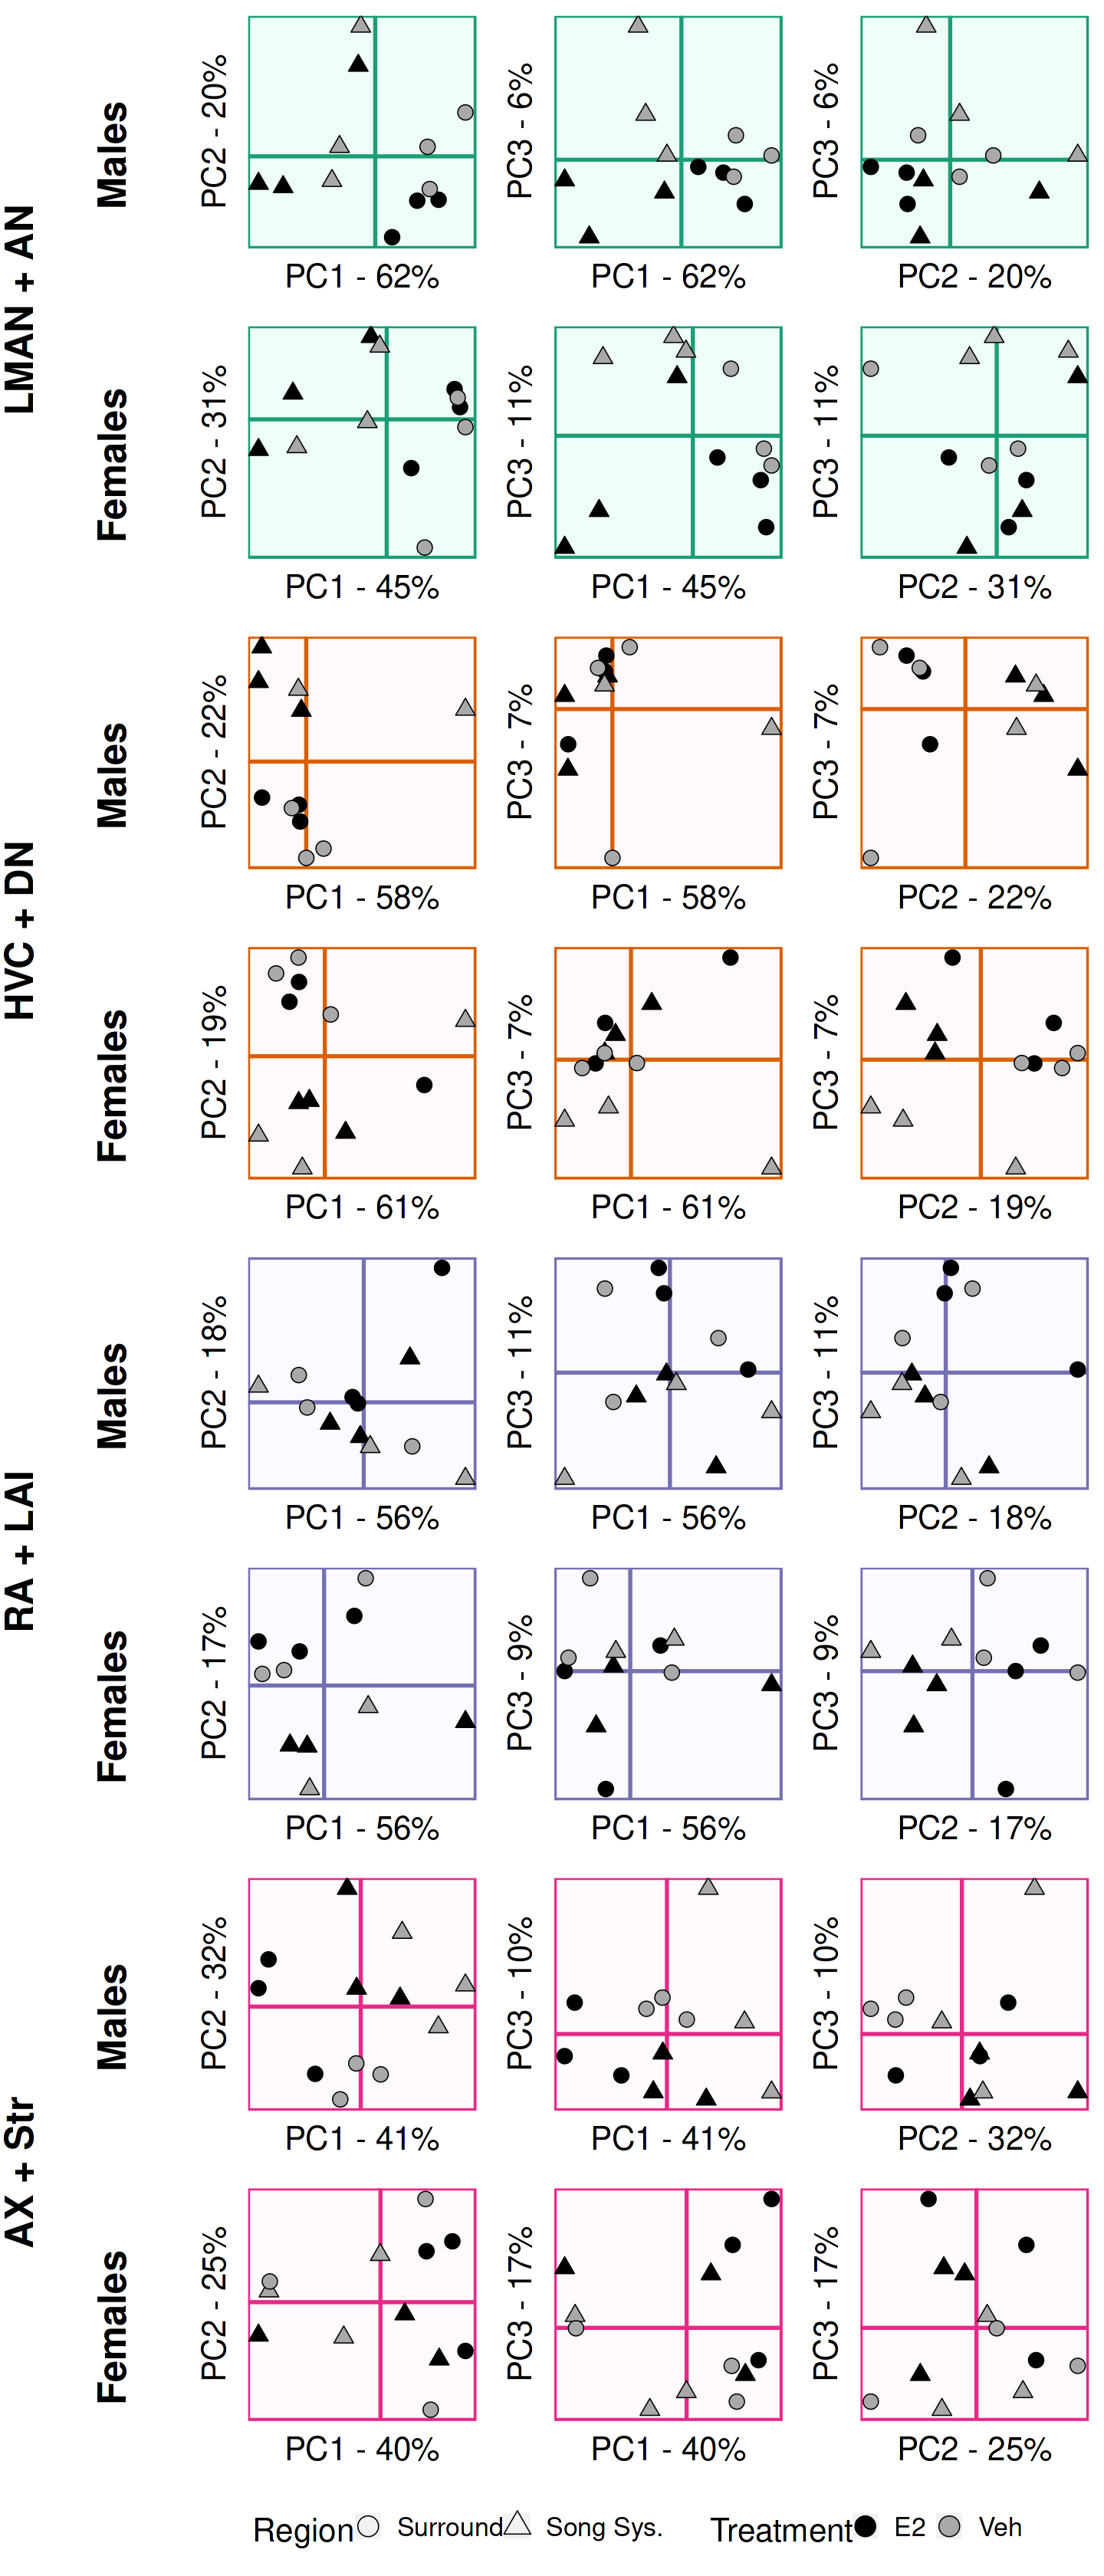

In [18]:
options(repr.plot.width=12, repr.plot.height=28)
pca_plots_1 <- ggarrange(an_pcas$plots,dn_pcas$plots,la_pcas$plots,str_pcas$plots,lgnd_row,ncol=1,heights =c(1,1,1,1,.15))
pca_plots_1

ggsave(file='svg_files/figs4_PCAs.svg', plot=pca_plots_1, width = 12,height = 28)

## Reviewer wants sexes together, so lets just do song regions. 3 categorical labels is too many for ascatter

In [19]:
pca_list2 <- list()
pca_list2$lman <- rbind(gen_list$m_an %>% filter(region=='lman'), gen_list$f_an %>% filter(region=='lman'))
pca_list2$hvc <-  rbind(gen_list$m_dn %>% filter(region=='hvc'), gen_list$f_dn %>% filter(region=='hvc'))
pca_list2$ra <-   rbind(gen_list$m_la %>% filter(region=='ra'), gen_list$f_la %>% filter(region=='ra'))
pca_list2$ax <-   rbind(gen_list$m_str %>% filter(region=='ax'), gen_list$f_str %>% filter(region=='ax'))

In [20]:
pca_tbls2<- pca_list2 %>% lapply(function(tbl){
        
    a<-tbl %>% dplyr::select(sample_id, gene_id, fpkm) %>% 
        pivot_wider(names_from='sample_id',values_from='fpkm') %>% dplyr::select(-gene_id) %>%
        as.matrix %>% t %>% prcomp %>% summary

    res<-list()
    res$PCed_samps <- a$x %>% as_tibble(rownames = 'sample_id') %>% left_join(hana_design,by='sample_id')
    res$var_explained <- a$importance
    return(res)
    
})

In [21]:
pca_tbls2$hvc %>% head

sample_id,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,animal,sex,dose,pallia,region,song_capable,node,song_system
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
me_hvc_1,-1558.857,466.7715,334.0086,1205.3288,450.24272,-592.2937,-2032.70815,11.13451,-2.971581,-27.899960,-5.855341e-12,g,m,e,nido,hvc,y,dn,y
me_hvc_2,-5075.902,188.8924,1900.3015,1239.2427,1102.78894,-1178.5780,967.21529,780.94970,-252.514981,64.412400,8.830412e-12,h,m,e,nido,hvc,y,dn,y
me_hvc_3,-4744.769,1084.3018,3703.3045,-2536.2958,-359.71768,862.1879,-239.85202,144.74771,-82.224164,-10.986665,3.613115e-12,i,m,e,nido,hvc,y,dn,y
mv_hvc_2,-2055.482,1310.9356,587.0538,327.2975,-764.13443,-864.1149,460.10130,-1624.77754,89.054735,3.787344,3.630613e-12,k,m,v,nido,hvc,y,dn,y
mv_hvc_3,11501.544,4940.7091,-661.0867,-424.2889,-302.16460,-263.8513,154.75946,445.51738,-92.106520,-135.098428,-1.525318e-11,l,m,v,nido,hvc,y,dn,y
fe_hvc_1,-1912.737,-482.2791,-962.0391,1077.1992,-1782.20724,433.5729,67.76486,462.96611,52.625749,840.966917,9.762261e-12,a,f,e,nido,hvc,y,dn,y
fe_hvc_2,-1296.342,-373.9913,-129.8210,1195.3973,-66.71222,790.7582,283.19621,187.70723,1311.845714,-556.992212,4.709326e-12,b,f,e,nido,hvc,y,dn,y
fe_hvc_3,1359.256,223.4991,-540.9213,1292.6603,1363.97702,1637.4420,219.26693,-513.47699,-737.865330,82.075583,-3.504666e-12,c,f,e,nido,hvc,y,dn,y
fv_hvc_1,-5111.395,-1472.3541,-2795.2499,-725.0578,-941.86619,-173.0882,53.01027,271.48077,-763.885545,-678.718714,-9.611022e-12,d,f,v,nido,hvc,n,dn,y


In [22]:
pca_plotter2 <- function(s_bleh,color,title){

    a<- s_bleh$PCed_samps %>% ggplot(aes(x=PC1,y=PC2,fill=dose,shape=sex=='m')) +
            geom_point(size=5) +
            xlab(paste('PC1 - ',round(s_bleh$var_explained[2,1]*100), '%',sep='')) +
            ylab(paste('PC2 - ',round(s_bleh$var_explained[2,2]*100), '%',sep='')) + 
            scale_shape_manual("Sex",values = c(21,24),labels=c('F','M'))+
            scale_fill_manual("Treatment",values=c('black', 'dark grey'), labels = c('E2', ('Veh'))) +
            scale_y_continuous(breaks=c(0)) +
            scale_x_continuous(breaks=c(0)) +
            theme_grey(base_size=25) + 
            theme(legend.position='bottom',
                 axis.text = element_blank(), axis.ticks = element_blank(),
                 panel.background = element_rect(fill = lighten(color,amount = 0.97), color=color),
                 panel.grid = element_line(color=color)) +
            guides(fill = guide_legend(override.aes = list(shape = 21,size=7) ),
                   shape = guide_legend(override.aes = list(size=7) ) )

    b<- s_bleh$PCed_samps %>% ggplot(aes(x=PC1,y=PC3,fill=dose,shape=sex=='m')) +
            geom_point(size=5) +
            xlab(paste('PC1 - ',round(s_bleh$var_explained[2,1]*100), '%',sep='')) +
            ylab(paste('PC3 - ',round(s_bleh$var_explained[2,3]*100), '%',sep='')) + 
            scale_shape_manual("Sex",values = c(21,24),labels=c('F','M'))+
            scale_fill_manual("Treatment",values=c('black', 'dark grey'), labels = c('E2', ('Veh'))) +
            scale_y_continuous(breaks=c(0)) +
            scale_x_continuous(breaks=c(0)) +
            theme_grey(base_size=25) + 
            theme(legend.position='none',
                 axis.text = element_blank(), axis.ticks = element_blank(),
                 panel.background = element_rect(fill = lighten(color,amount = 0.97), color=color),
                 panel.grid = element_line(color=color)) +
            guides(fill = guide_legend(override.aes = list(shape = 21,size=7) ),
                   shape = guide_legend(override.aes = list(size=7) ) )

    c<- s_bleh$PCed_samps %>% ggplot(aes(x=PC2,y=PC3,fill=dose,shape=sex=='m')) +
            geom_point(size=5) +
            xlab(paste('PC2 - ',round(s_bleh$var_explained[2,2]*100), '%',sep='')) +
            ylab(paste('PC3 - ',round(s_bleh$var_explained[2,3]*100), '%',sep='')) + 
            scale_shape_manual("Sex",values = c(21,24),labels=c('F','M'))+
            scale_fill_manual("Treatment",values=c('black', 'dark grey'), labels = c('E2', ('Veh'))) +
            scale_y_continuous(breaks=c(0)) +
            scale_x_continuous(breaks=c(0)) +
            theme_grey(base_size=25) + 
            theme(legend.position='none',
                 axis.text = element_blank(), axis.ticks = element_blank(),
                 panel.background = element_rect(fill = lighten(color,amount = 0.97), color=color),
                 panel.grid = element_line(color=color)) +
            guides(fill = guide_legend(override.aes = list(shape = 21,size=7) ),
                   shape = guide_legend(override.aes = list(size=7) ) )


    res <- list()
    lgnd <- g_legend(a)
    res$legend <- lgnd
    a <- a + theme(legend.position='none')
    #row1 <- ggarrange(a, b, nrow=1,widths =c(1,1))
    #row2 <- ggarrange(NULL,c,NULL,nrow=1, widths=c(.5,1,.5))

    res$plots <- ggarrange(a,b,c,nrow=3)%>%
    annotate_figure(top=text_grob(title,size=30,face='bold'))
    return(res)
}


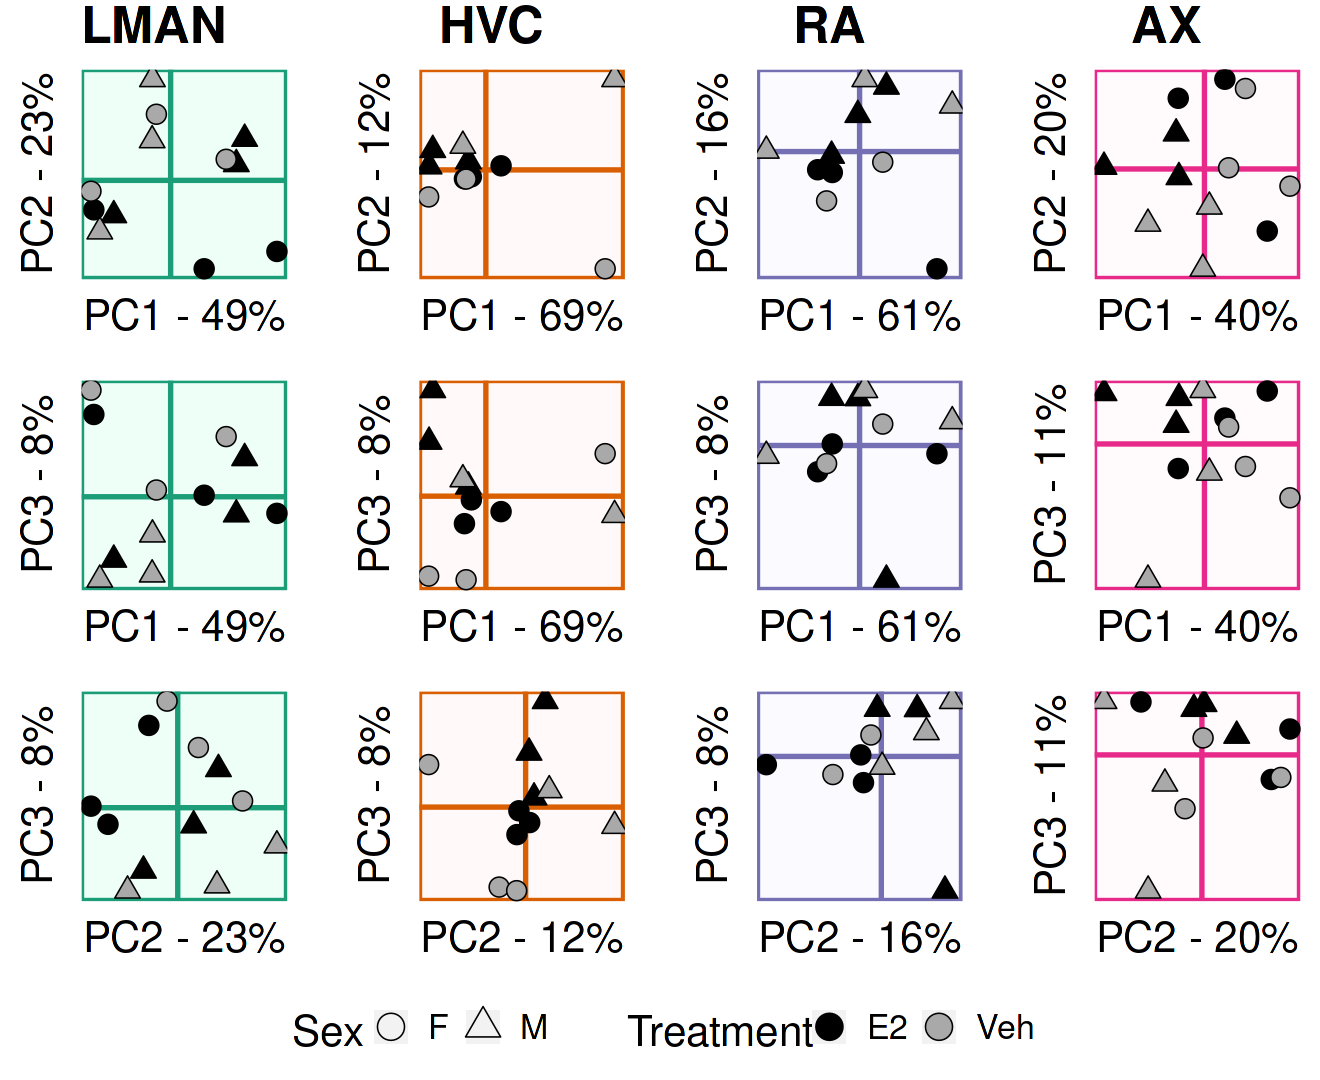

In [23]:
options(repr.plot.width=11, repr.plot.height=9)

an_pcas2 <- pca_plotter2(pca_tbls2$lman,"#1b9e77",'LMAN')
dn_pcas2 <- pca_plotter2(pca_tbls2$hvc,"#d95f02",'HVC')
la_pcas2 <- pca_plotter2(pca_tbls2$ra,"#7570b3",'RA')
str_pcas2 <- pca_plotter2(pca_tbls2$ax,"#e7298a",'AX')
song_sys_pca<-ggarrange(an_pcas2$plots,NULL,dn_pcas2$plots,NULL,la_pcas2$plots,NULL,str_pcas2$plots,nrow=1,
         widths=c(1,.1,1,.1,1,.1,1))
song_sys_pca<-ggarrange(song_sys_pca,an_pcas2$legend,ncol=1,heights=c(1,.1))

song_sys_pca
ggsave(file='svg_files/remade_PCAs_again_again.svg',plot=song_sys_pca, width = 11, height = 9)

## Nice, the reviewers also wanted some dendrograms with pvals so lets give them those 

In [25]:
library(pvclust)

### Takes a while

In [30]:
pvclust_list <- pca_list %>% lapply(function(tbl){
    tmp<-tbl%>% dplyr::select(sample_id, gene_id, fpkm) %>% 
        pivot_wider(names_from='sample_id',values_from='fpkm') %>% dplyr::select(-gene_id) %>%
        as.matrix 
    #cleanup the names
    colnames(tmp) <- colnames(tmp) %>% lapply(function(id){
    id %>% str_replace('mv','male_veh') %>% str_replace('me','male_e2') %>% 
        str_replace('fe','female_e2') %>% str_replace('fv','female_veh') %>%
        str_replace('mst','str') %>%
        str_replace('pln','dn') %>% paste('  ')
    })
    tmp %>% pvclust(iseed=42) #42, the answer
    }
)

Bootstrap (r = 0.5)... Done.
Bootstrap (r = 0.6)... Done.
Bootstrap (r = 0.7)... Done.
Bootstrap (r = 0.8)... Done.
Bootstrap (r = 0.9)... Done.
Bootstrap (r = 1.0)... Done.
Bootstrap (r = 1.1)... Done.
Bootstrap (r = 1.2)... Done.
Bootstrap (r = 1.3)... Done.
Bootstrap (r = 1.4)... Done.
Bootstrap (r = 0.5)... Done.
Bootstrap (r = 0.6)... Done.
Bootstrap (r = 0.7)... Done.
Bootstrap (r = 0.8)... Done.
Bootstrap (r = 0.9)... Done.
Bootstrap (r = 1.0)... Done.
Bootstrap (r = 1.1)... Done.
Bootstrap (r = 1.2)... Done.
Bootstrap (r = 1.3)... Done.
Bootstrap (r = 1.4)... Done.
Bootstrap (r = 0.5)... Done.
Bootstrap (r = 0.6)... Done.
Bootstrap (r = 0.7)... Done.
Bootstrap (r = 0.8)... Done.
Bootstrap (r = 0.9)... Done.
Bootstrap (r = 1.0)... Done.
Bootstrap (r = 1.1)... Done.
Bootstrap (r = 1.2)... Done.
Bootstrap (r = 1.3)... Done.
Bootstrap (r = 1.4)... Done.
Bootstrap (r = 0.5)... Done.
Bootstrap (r = 0.6)... Done.
Bootstrap (r = 0.7)... Done.
Bootstrap (r = 0.8)... Done.
Bootstrap (r =

In [31]:
options(repr.plot.width=18, repr.plot.height=15)
pvclust_plotter <- function(pv_data,color,title,flt){
plot.new()
rect(par("usr")[1], par("usr")[3],
     par("usr")[2], par("usr")[4],
     col = lighten(color,.97),
     border = color) # Color
par(new=TRUE)
pv_data %>% plot(cex.pv=2,cex=3,print.pv='au',main=title,cex.main=5,float=flt,xlab='',sub='',yaxt='n',ylab='')
}

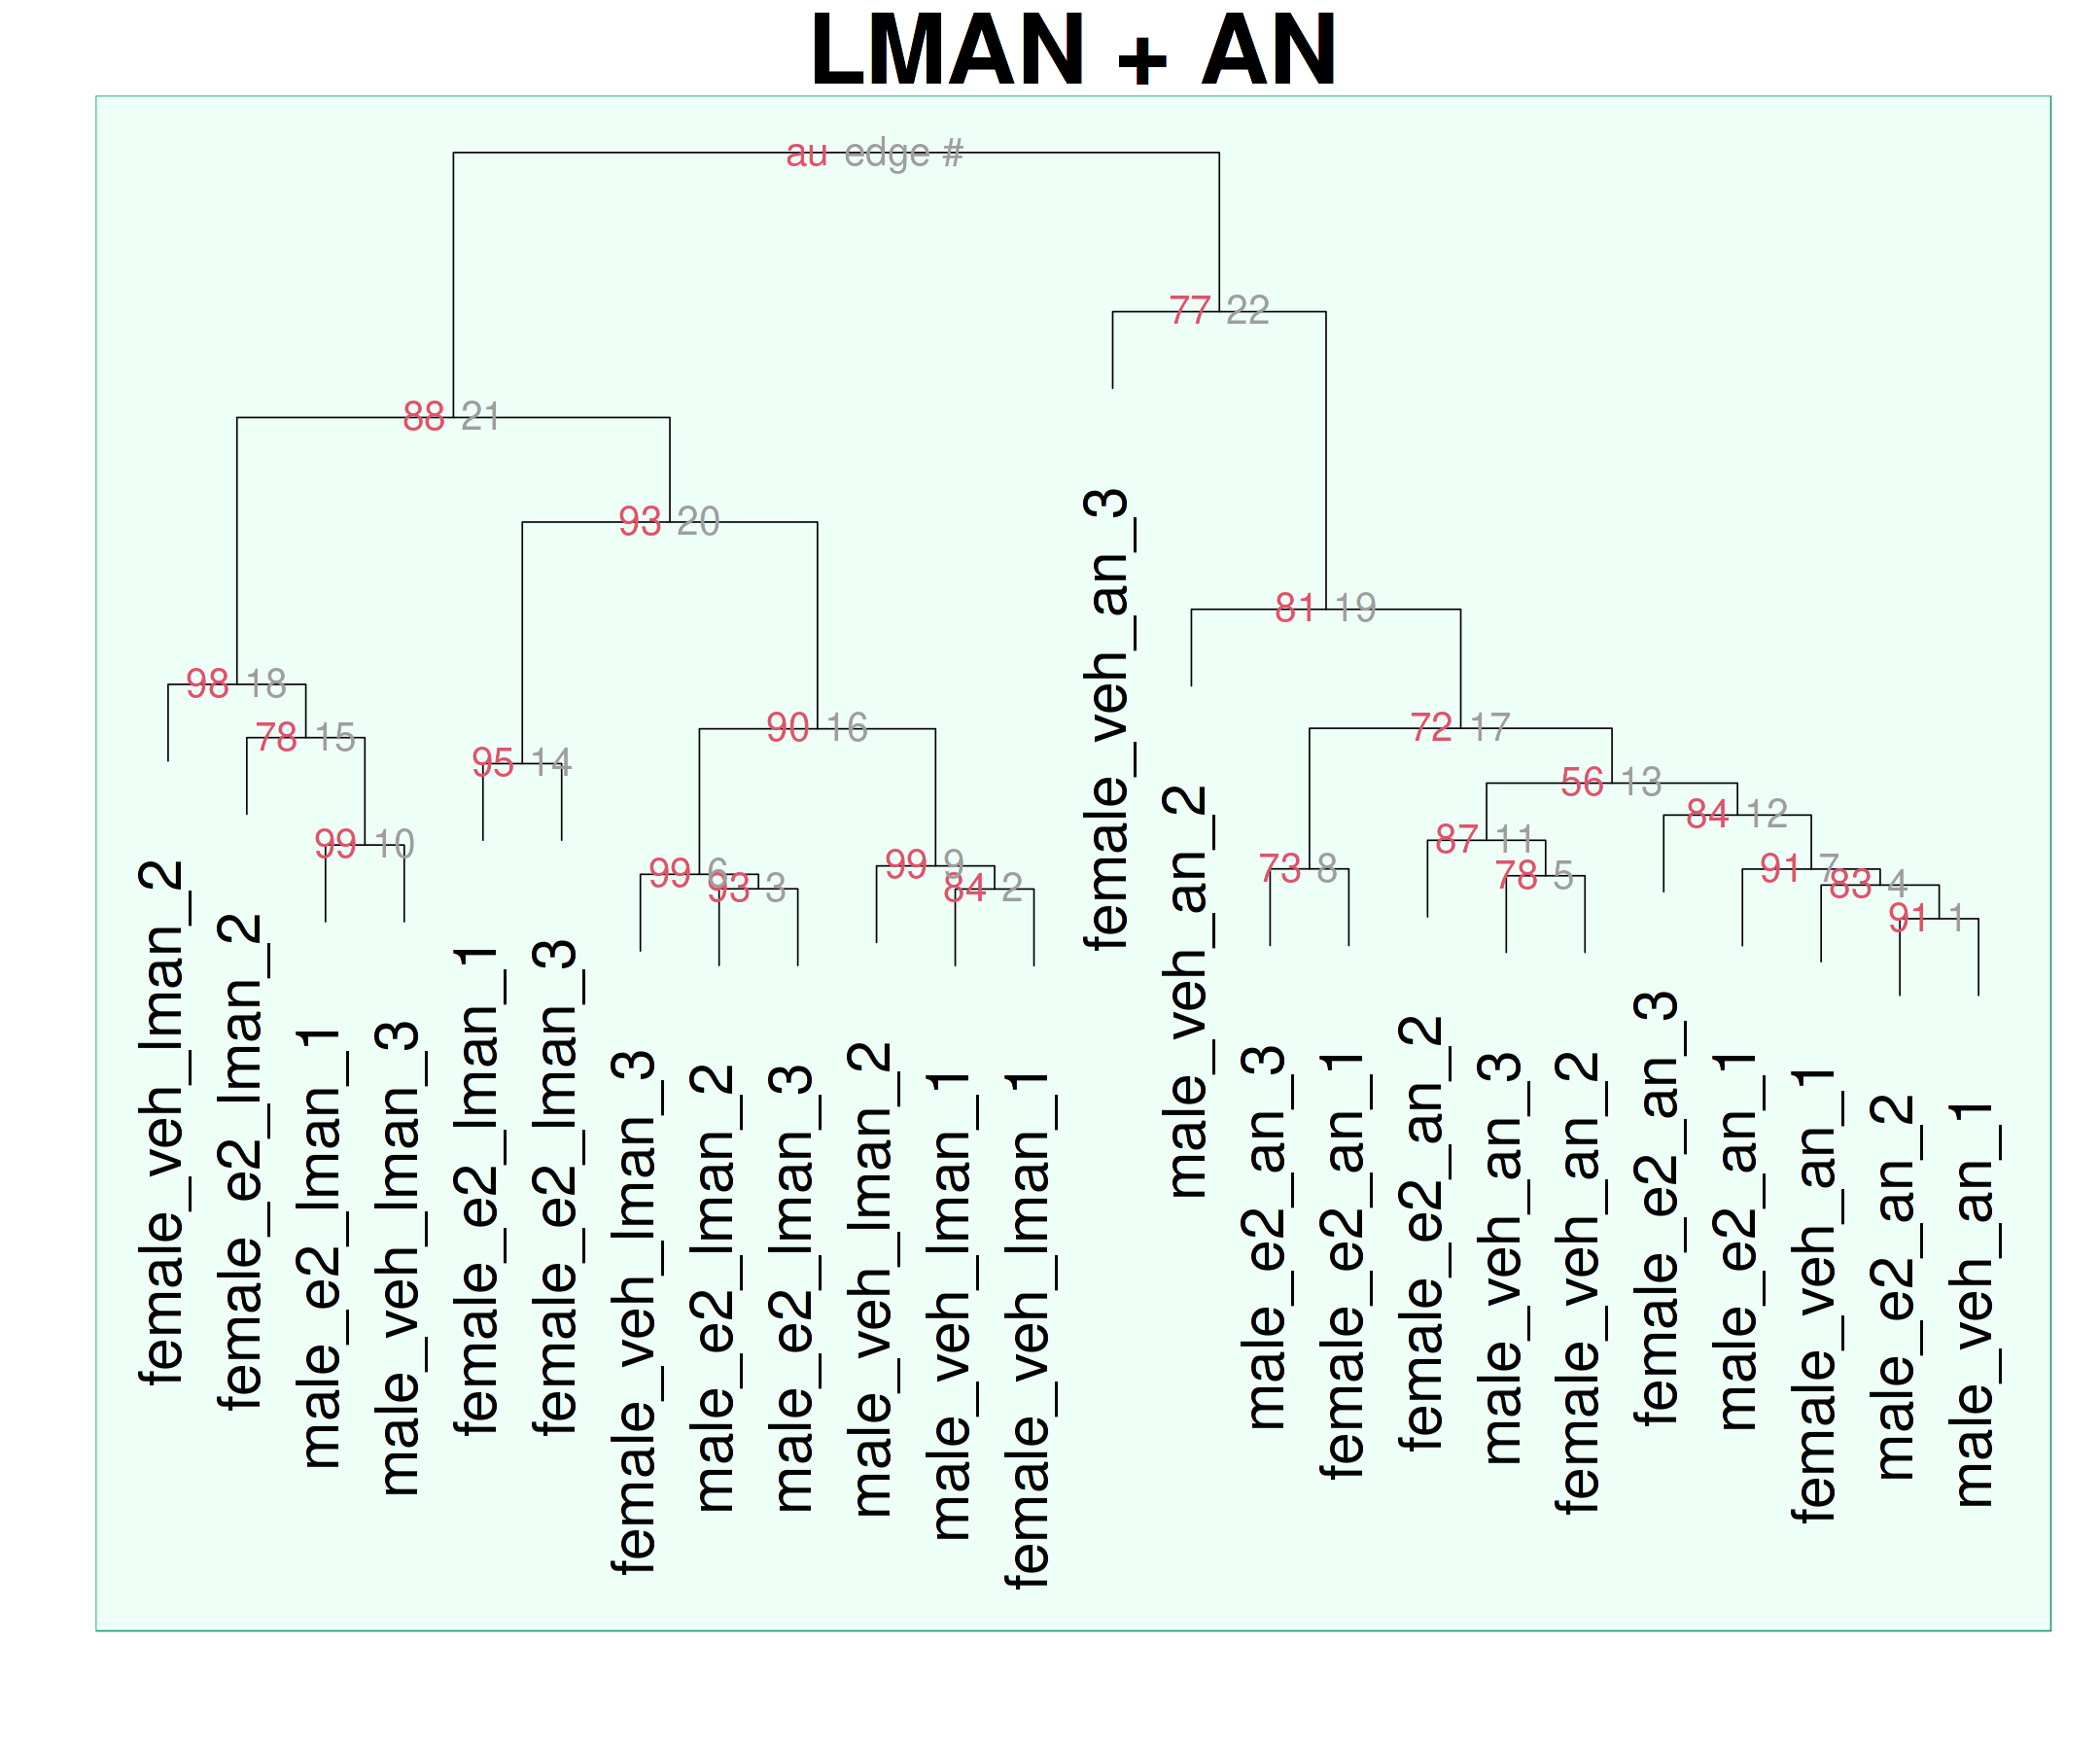

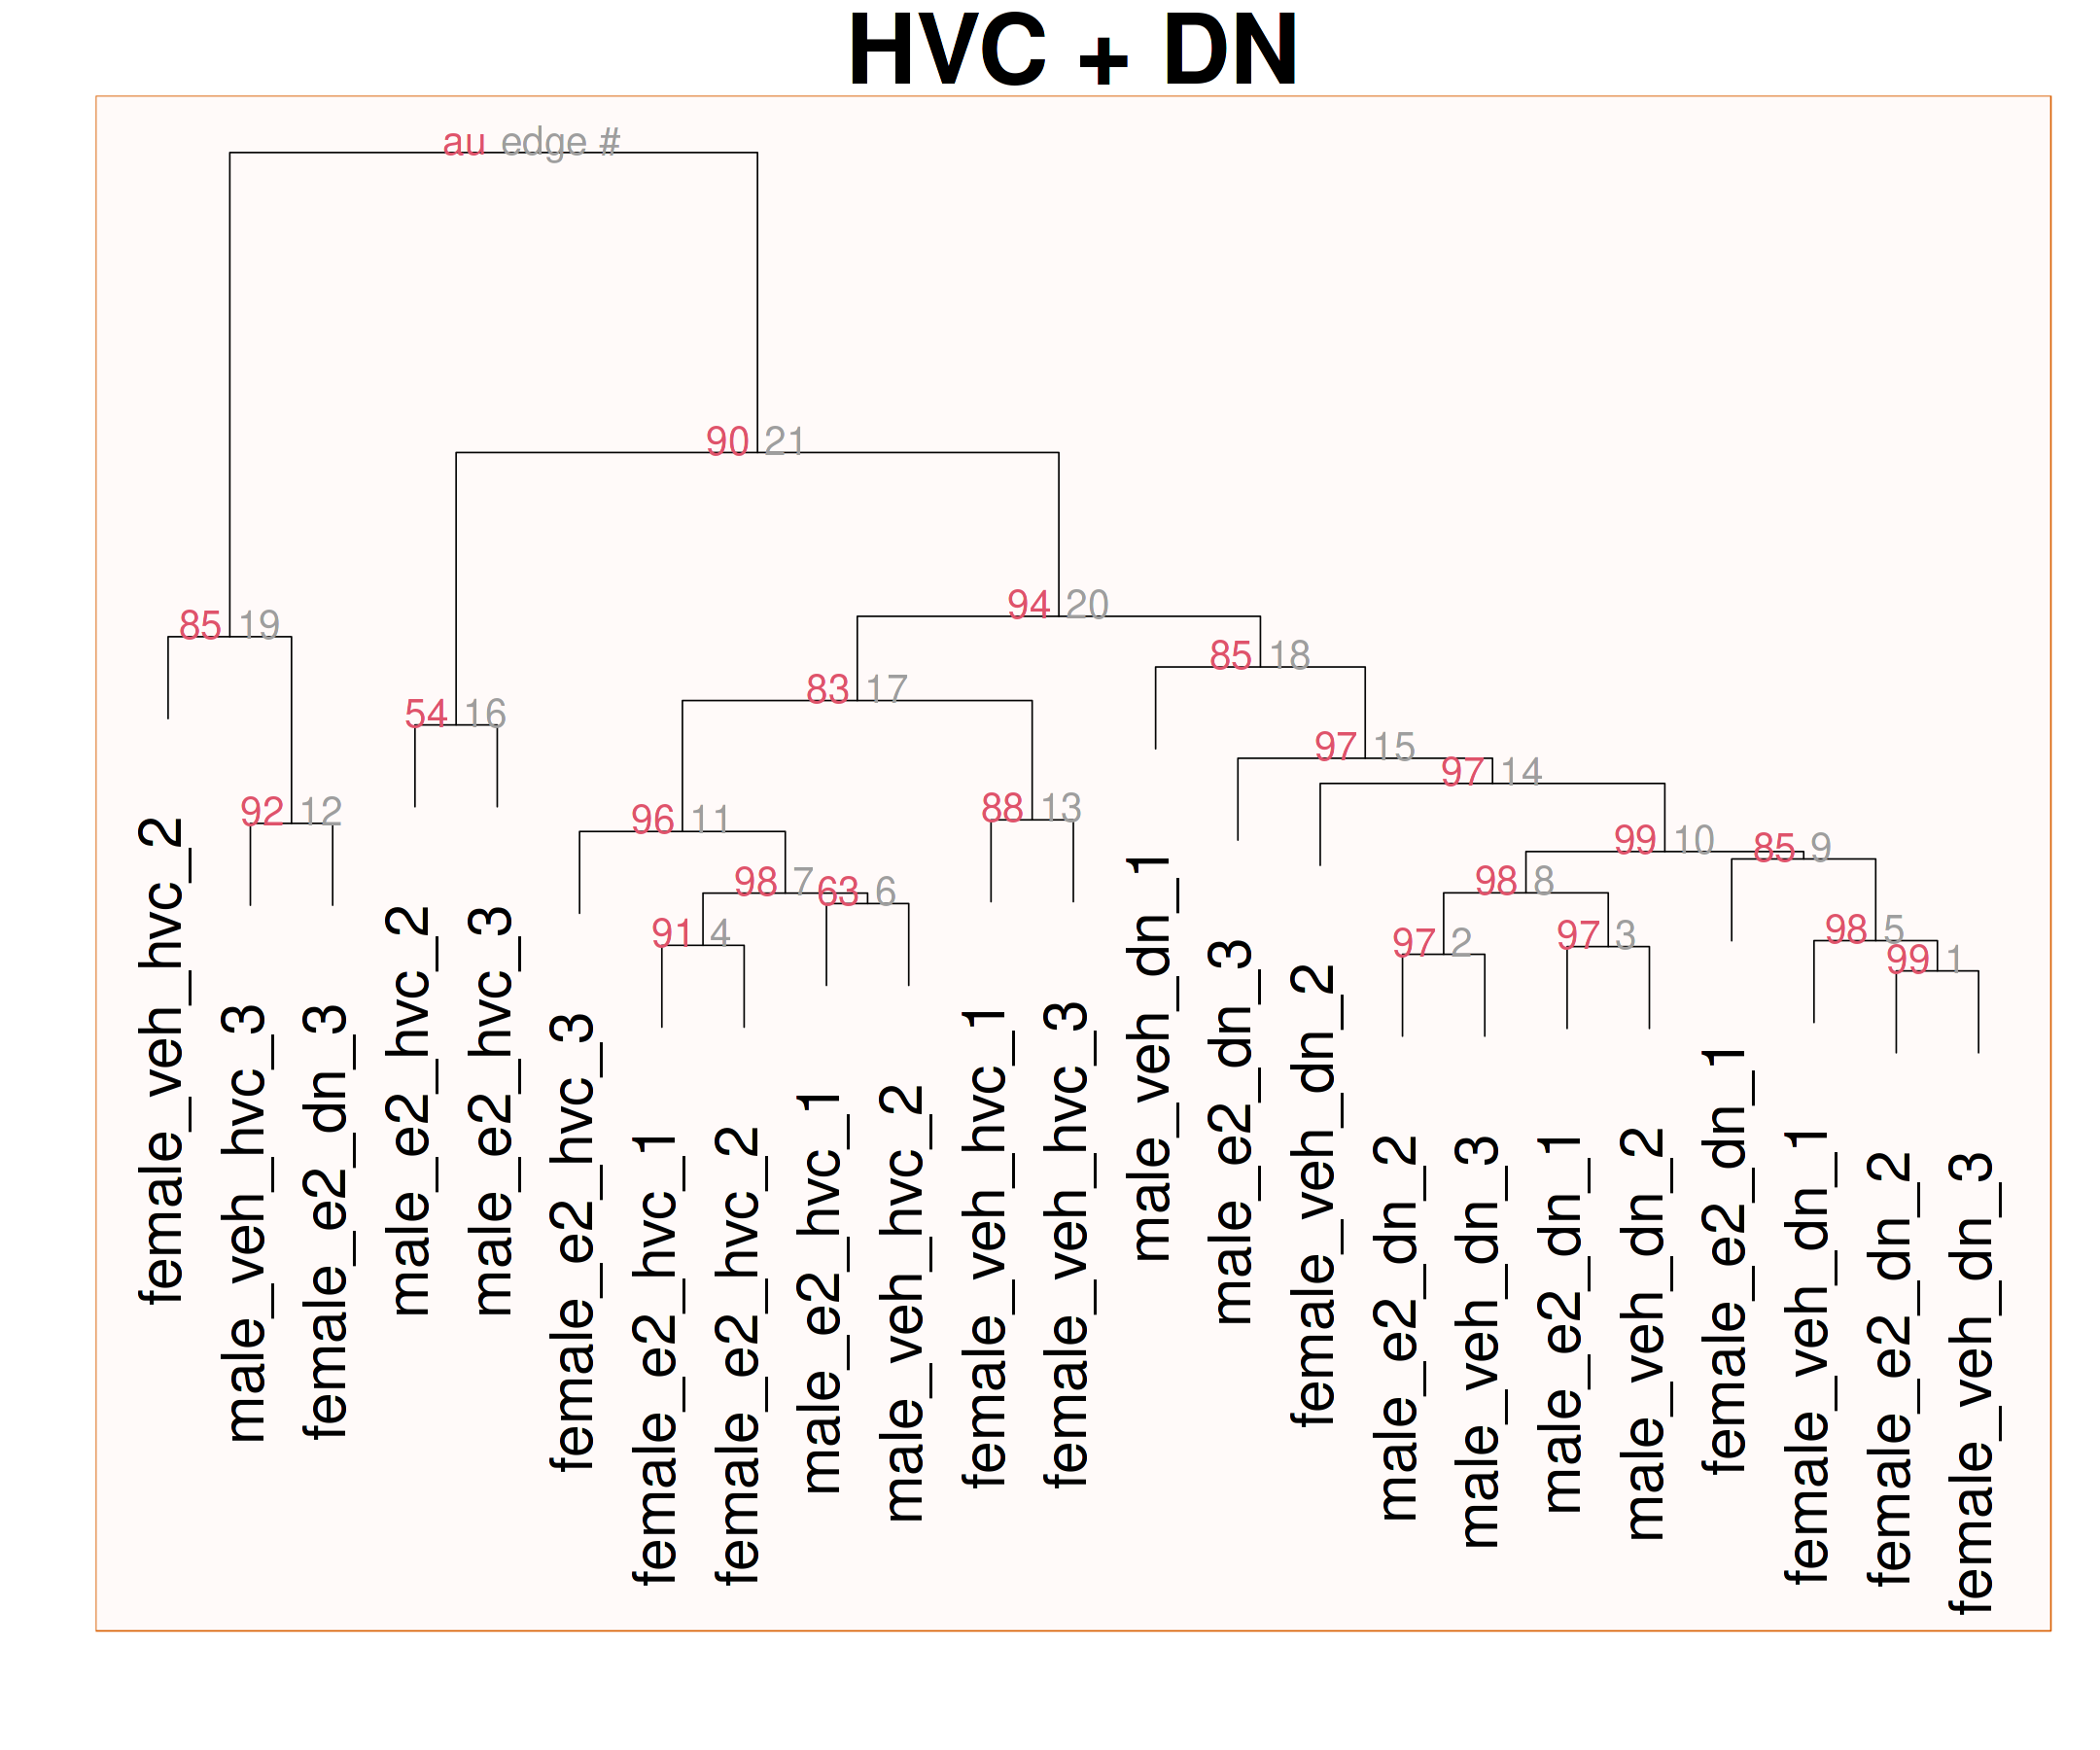

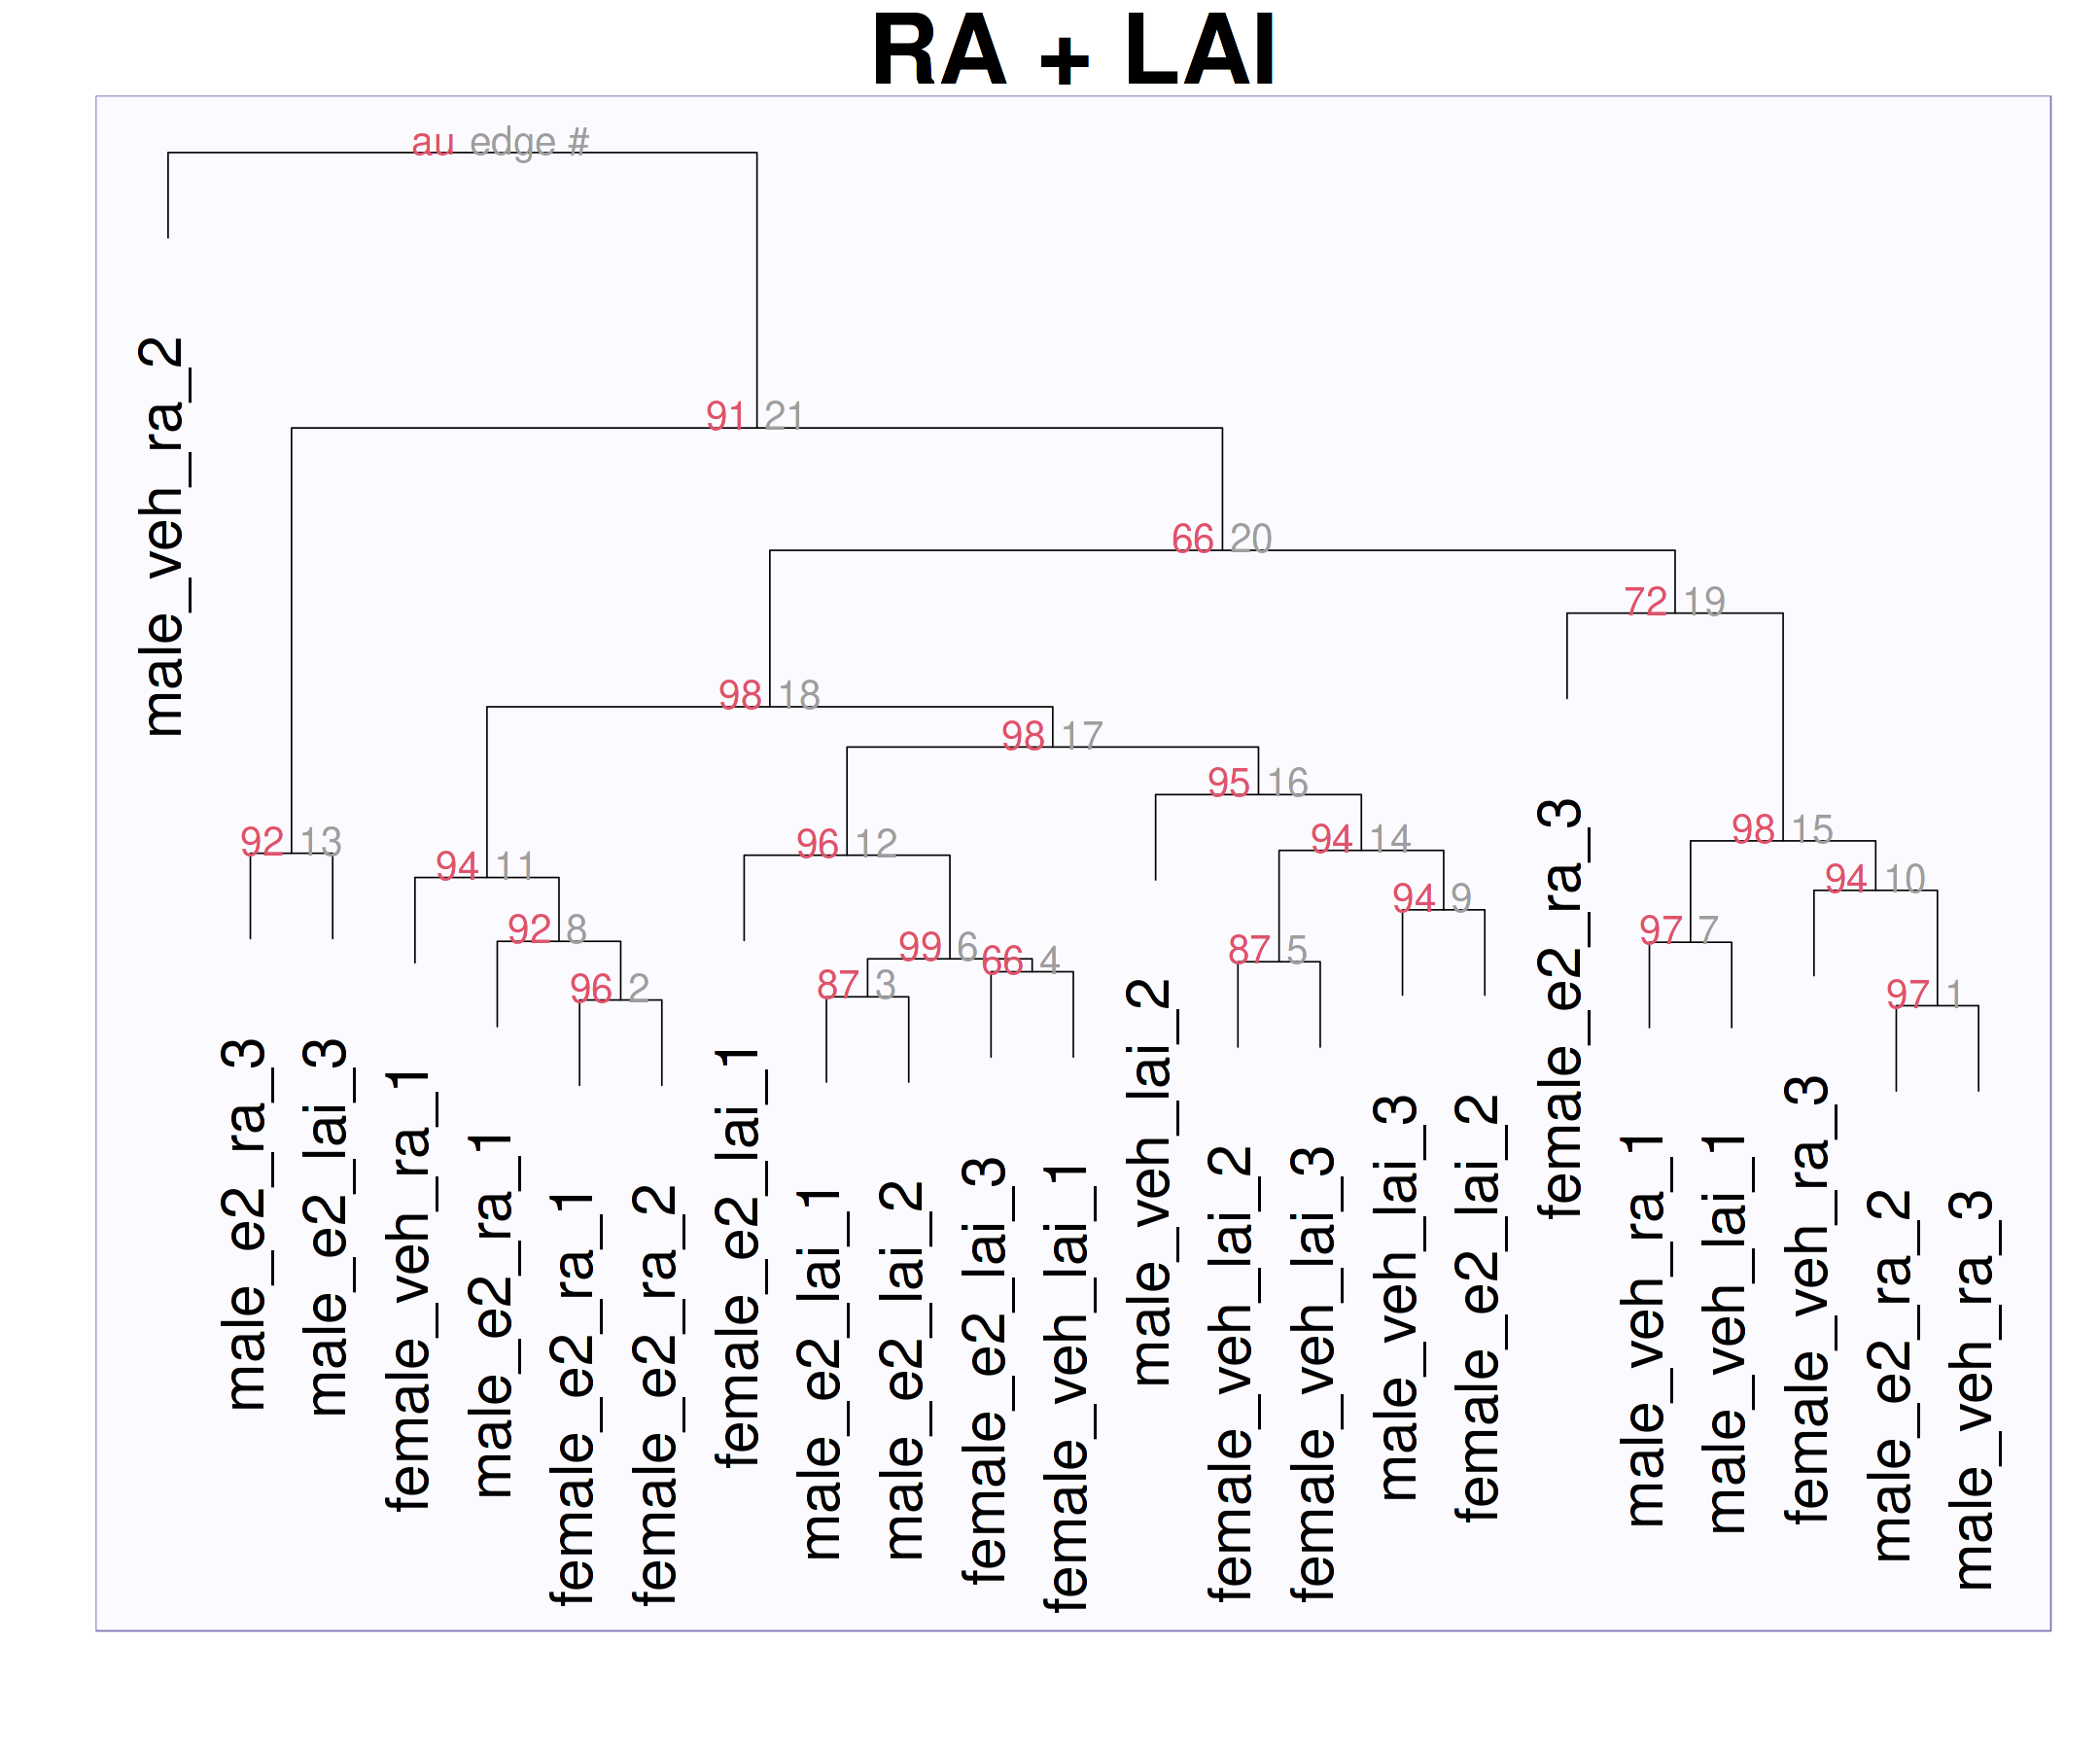

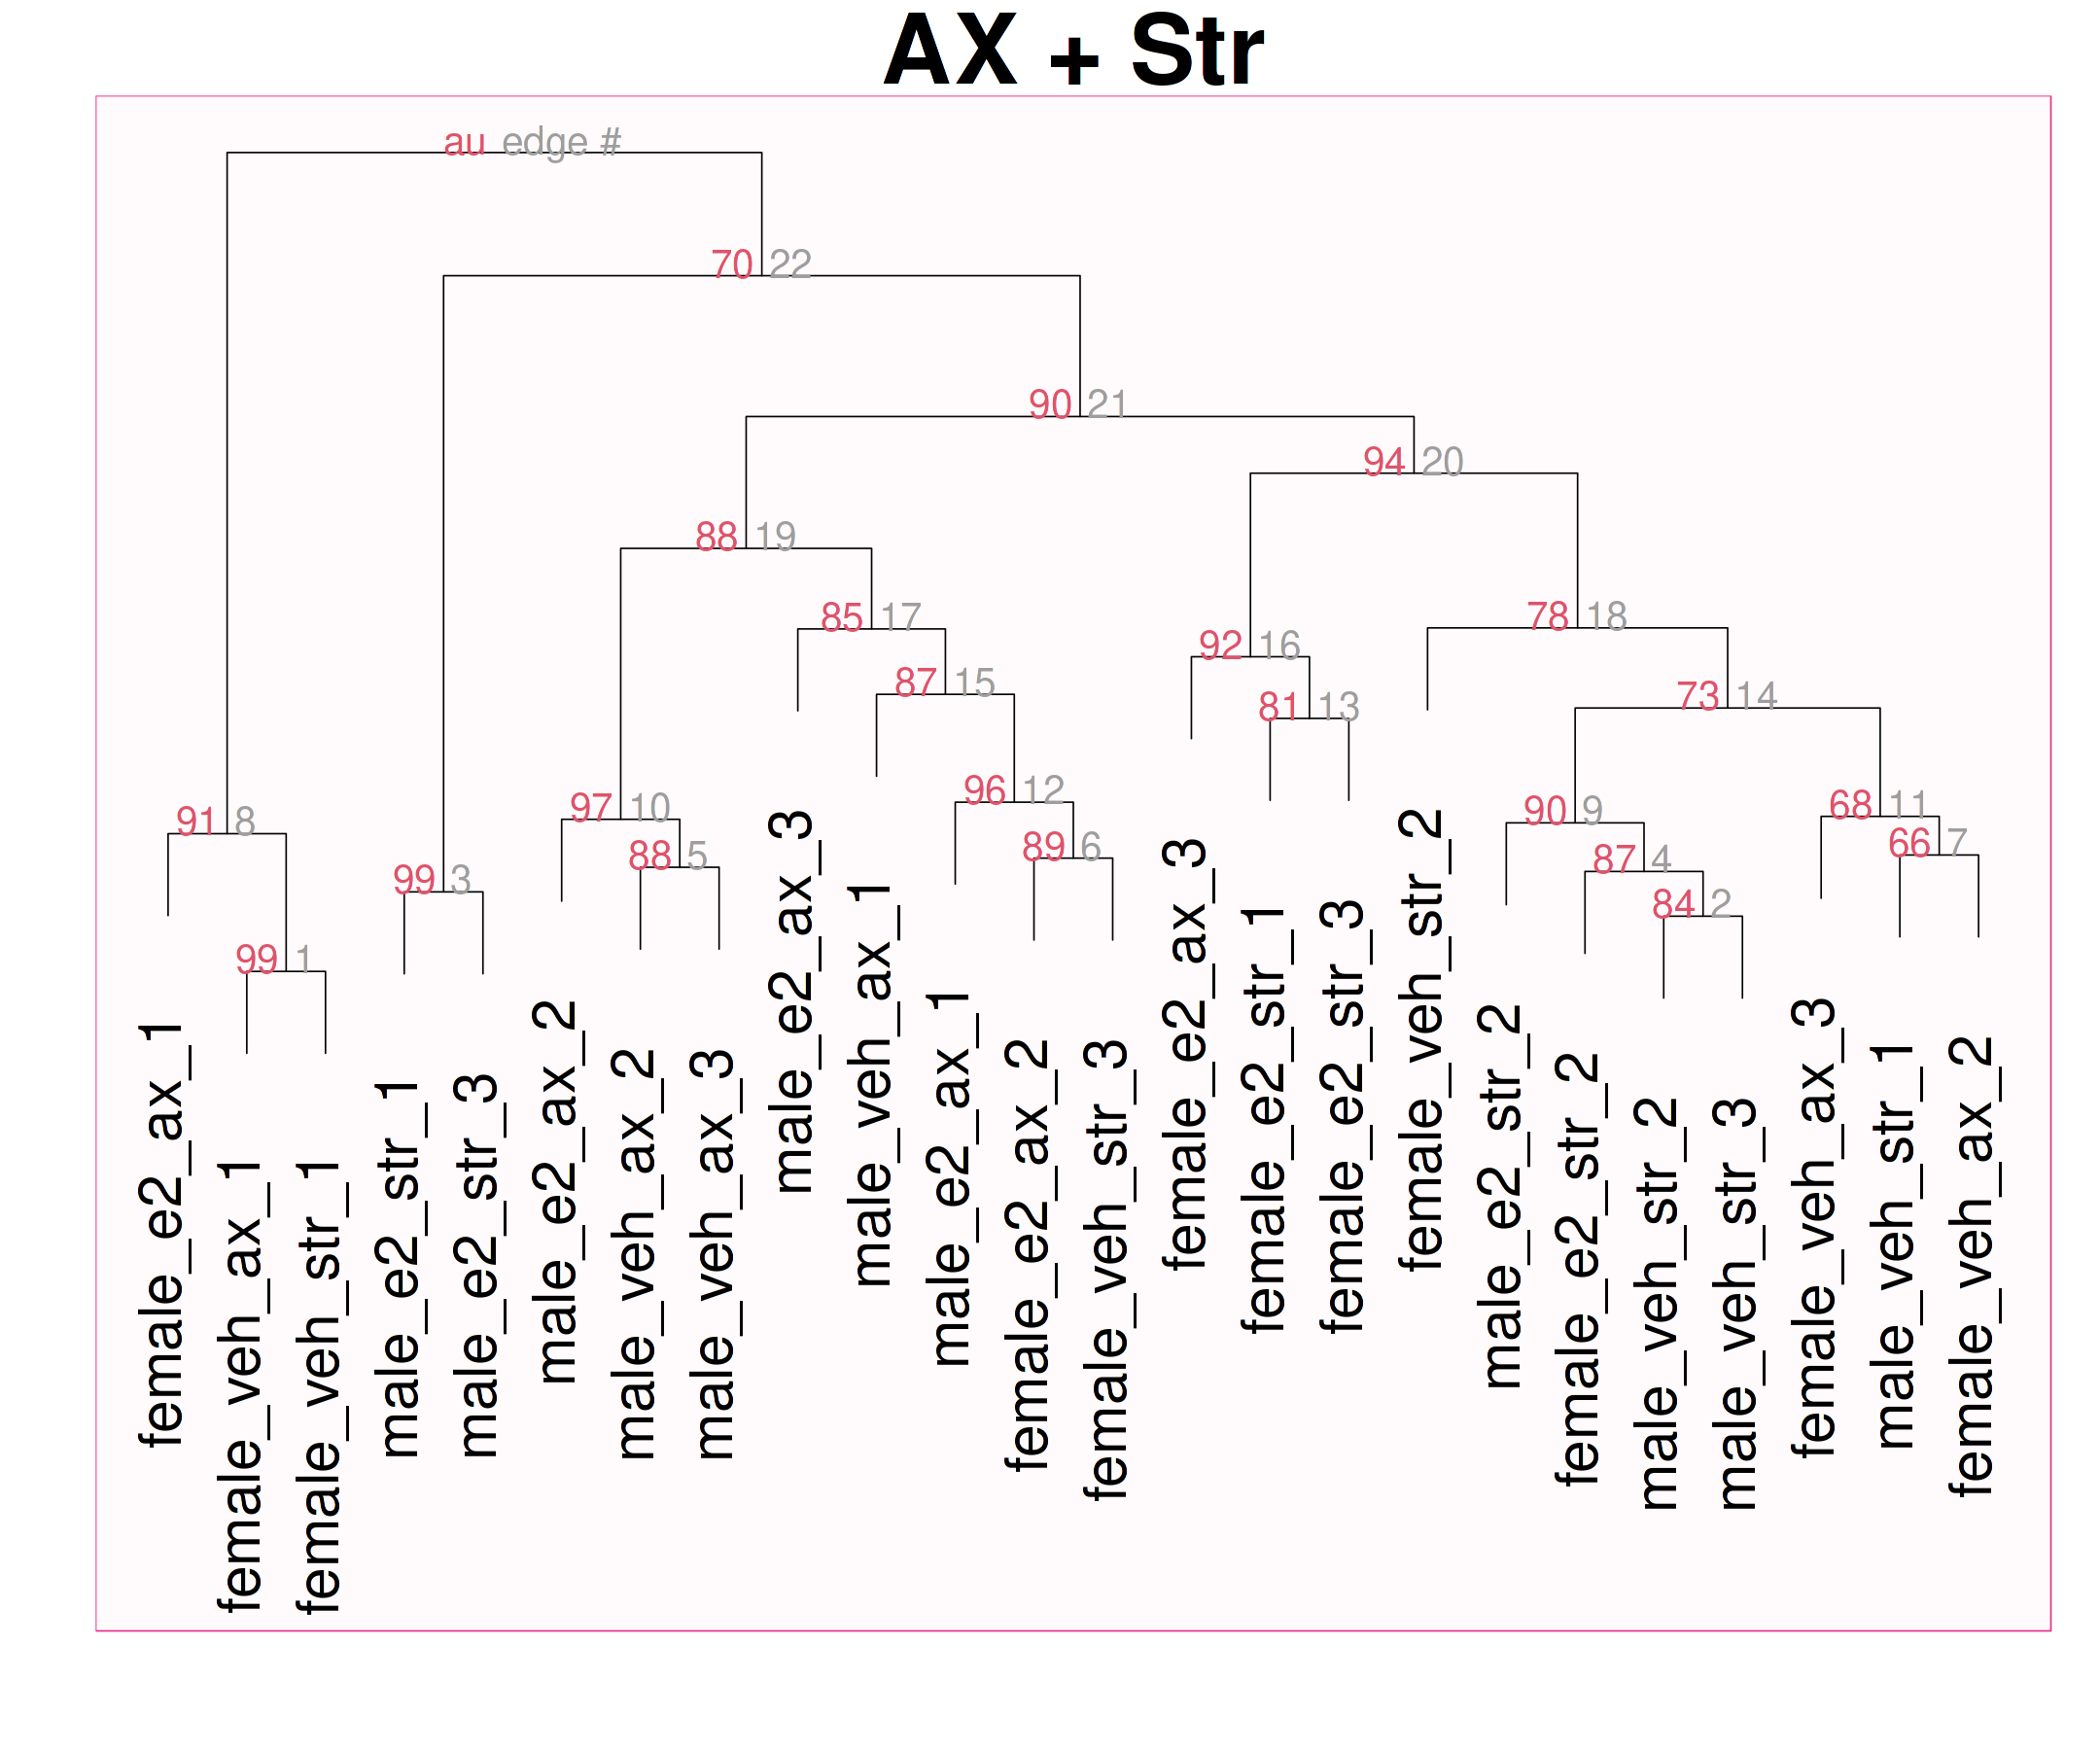

In [32]:
pvclust_plotter(pvclust_list$all_an,"#1b9e77",'LMAN + AN',-0.0003)
pvclust_plotter(pvclust_list$all_dn,"#d95f02", 'HVC + DN',0.0015)
pvclust_plotter(pvclust_list$all_la,"#7570b3", 'RA + LAI',0.0015)
pvclust_plotter(pvclust_list$all_str,"#e7298a", 'AX + Str',0.0015)

## Well the reviewer didn't think those were visually clear enough ^^^ so lets make prettier ones. 

In [33]:
#install.packages('dendextend')
library(dendextend)

ERROR: Error in library(dendextend): there is no package called ‘dendextend’


In [ ]:
pvclust_plotter2 <- function(plt_data, color,top,bottom=-.05){
dend <- as.dendrogram(plt_data) 
dend <- set(dend, "labels_cex", 1.8)
dend %>%
  pvclust_show_signif(pvclust_list$all_dn,alpha=.1,show_type = "lwd",signif_type='au') %>%
  as.ggdend() %>%

ggplot() + 
    theme_dendro() + ylim(bottom,top) + theme_void(base_size=30)+
    theme(panel.background = element_rect(fill = lighten(color,amount = 0.95), color=color))
}




In [ ]:
options(repr.plot.width=20,repr.plot.height=20)

an_hclust <- pvclust_plotter2(plt_data = pvclust_list$all_an, color = "#1b9e77", top=.12, bottom = -.1) + ggtitle('LMAN + AN')
dn_hclust <- pvclust_plotter2(plt_data = pvclust_list$all_dn, color = "#d95f02", top=.15, bottom = -.12) + ggtitle('HVC + DN')
la_hclust <- pvclust_plotter2(plt_data = pvclust_list$all_la, color = "#7570b3", top=.12,bottom=-.08) + ggtitle('RA + LAI')
str_hclust <- pvclust_plotter2(plt_data = pvclust_list$all_str, color = "#e7298a", top=.07, bottom = -.05) + ggtitle('AX + Str')

all_clust<-ggarrange(an_hclust,NULL,dn_hclust,NULL,NULL,NULL,la_hclust,NULL,str_hclust,nrow=3,ncol=3,widths = c(1,.1,1),heights = c(1,.1,1))
all_clust
ggsave('svg_files/all_pvclust_pretty.png',plot = all_clust,width = 20,height = 20)

In [ ]:
svg('svg_files/figs5_lmanClust.svg', height=15, width=18)
pvclust_plotter(pvclust_list$all_an,"#1b9e77",'LMAN + AN',-0.0003)
dev.off()

svg('svg_files/figs5_hvcClust.svg', height=15, width=18)
pvclust_plotter(pvclust_list$all_dn,"#d95f02", 'HVC + DN',0.0015)
dev.off()

svg('svg_files/figs5_raClust.svg', height=15, width=18)
pvclust_plotter(pvclust_list$all_la,"#7570b3", 'RA + LAI',0.0015)
dev.off()

svg('svg_files/figs5_axClust.svg', height=15, width=18)
pvclust_plotter(pvclust_list$all_str,"#e7298a", 'AX + Str',0.0015)
dev.off()

## Well that wasn't "clear enough" so lets do it again with just song elements and see it is "clearer"

In [ ]:
pvclust_list_2 <- pca_list %>% lapply(function(tbl){
    tmp<-tbl %>% filter(song_system=='y') %>% dplyr::select(sample_id, gene_id, fpkm) %>% 
        pivot_wider(names_from='sample_id',values_from='fpkm') %>% dplyr::select(-gene_id) %>%
        as.matrix 
    #cleanup the names
    colnames(tmp) <- colnames(tmp) %>% lapply(function(id){
    id %>% str_replace('mv','male_veh') %>% str_replace('me','male_e2') %>% 
        str_replace('fe','female_e2') %>% str_replace('fv','female_veh') %>%
        str_replace('mst','str') %>%
        str_replace('pln','dn') %>% paste('  ')
    })
    tmp %>% pvclust(iseed=42) #42, the answer
    }
)

In [ ]:
options(repr.plot.width=20,repr.plot.height=20)

an_hclust <- pvclust_plotter2(plt_data = pvclust_list_2$all_an, color = "#1b9e77", top=.1, bottom = -.1) + ggtitle('LMAN + AN')
dn_hclust <- pvclust_plotter2(plt_data = pvclust_list_2$all_dn, color = "#d95f02", top=.19, bottom = -.12) + ggtitle('HVC + DN')
la_hclust <- pvclust_plotter2(plt_data = pvclust_list_2$all_la, color = "#7570b3", top=.12,bottom=-.08) + ggtitle('RA + LAI')
str_hclust <- pvclust_plotter2(plt_data = pvclust_list_2$all_str, color = "#e7298a", top=.07, bottom = -.05) + ggtitle('AX + Str')

all_clust<-ggarrange(an_hclust,NULL,dn_hclust,NULL,NULL,NULL,la_hclust,NULL,str_hclust,nrow=3,ncol=3,widths = c(1,.1,1),heights = c(1,.1,1))
all_clust

## WAY WORSE don't know why I thought that was a good idea